In [7]:
import zipfile
import joblib
import yaml
import io
from pathlib import Path

class ScalingZipLoader:
    def __init__(self, zip_path):
        self.zip_path = Path(zip_path)
        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ไม่พบไฟล์ ZIP: {zip_path}")

        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

    def load(self):
        """โหลด input/output scaler และ metadata จาก ZIP"""
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            # ✅ โหลด input_scaler.pkl
            with zipf.open("input_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_in = joblib.load(buffer)

            # ✅ โหลด output_scaler.pkl
            with zipf.open("output_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_out = joblib.load(buffer)

            # ✅ โหลด metadata.yaml
            with zipf.open("metadata.yaml") as f:
                self.metadata = yaml.safe_load(f)

        print(f"📦 Loaded ZIP successfully: {self.zip_path}")
        return self.scaler_in, self.scaler_out, self.metadata


if __name__ == "__main__":
    # 🧪 ตัวอย่างการใช้งาน
    zip_file = r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip"
    loader = ScalingZipLoader(zip_file)
    scaler_in, scaler_out, metadata = loader.load()

    print("\n🎯 Metadata summary:")
    print(yaml.dump(metadata, allow_unicode=True, sort_keys=False))

    # ✅ ตัวอย่างการใช้งาน scaler
    import numpy as np
    sample_input = np.array([[0.5]])
    scaled_input = scaler_in.transform(sample_input)
    print("\nSample input 0.5 scaled:", scaled_input)


📦 Loaded ZIP successfully: D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip

🎯 Metadata summary:
dataset_name: RC_Tank_Env_Training2
scaler_type: MinMaxScaler
num_files: 50
input_features:
- DATA_INPUT
output_features:
- DATA_OUTPUT
input_min:
- 0.0
input_max:
- 24.0
output_min:
- 0.08
output_max:
- 23.998895762088527


Sample input 0.5 scaled: [[0.02083333]]


Epoch 1/50, Loss: 0.177531
Epoch 5/50, Loss: 0.061274
Epoch 10/50, Loss: 0.025124
Epoch 15/50, Loss: 0.006801
Epoch 20/50, Loss: 0.002583
Epoch 25/50, Loss: 0.001128
Epoch 30/50, Loss: 0.000525
Epoch 35/50, Loss: 0.000275
Epoch 40/50, Loss: 0.000188
Epoch 45/50, Loss: 0.000155
Epoch 50/50, Loss: 0.000133


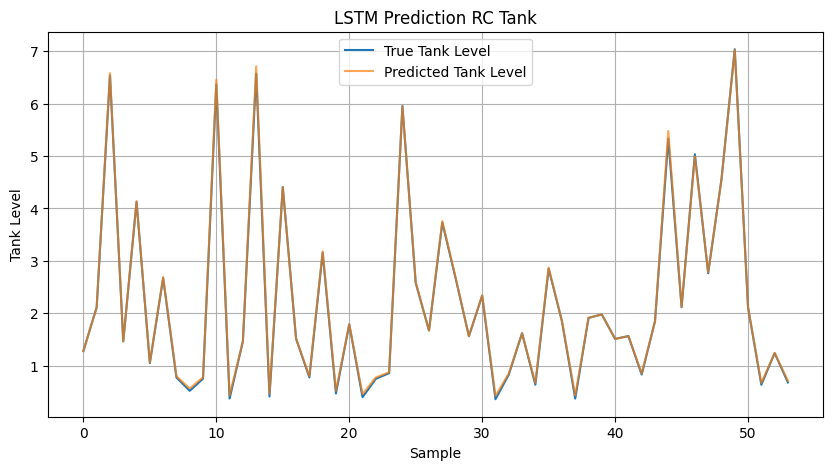

In [8]:
# -----------------------------
# LSTM RC Tank Prediction Example
# -----------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# -----------------------------
# Load dataset
# -----------------------------
data_file = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.10_freq_0.10_pwm.csv"
df = pd.read_csv(data_file)

# -----------------------------
# Load scalers (จาก ZIP ก็ได้)
# -----------------------------
# ตัวอย่างใช้ MinMaxScaler ใหม่
input_features = ["DATA_INPUT", "DATA_OUTPUT"]
output_features = ["DATA_OUTPUT"]

scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

X_scaled = scaler_in.fit_transform(df[input_features].values)
y_scaled = scaler_out.fit_transform(df[output_features].values)

# -----------------------------
# สร้าง sequences สำหรับ LSTM
# -----------------------------
window_size = 30

def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size=window_size)

# แบ่ง train/val/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# แปลงเป็น torch.Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# -----------------------------
# สร้าง LSTM model
# -----------------------------
class LSTM_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

model = LSTM_Predictor(input_size=input_size, hidden_size=64, num_layers=2, output_size=output_size)

# -----------------------------
# Training setup
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
batch_size = 64

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= X_train.size(0)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

# -----------------------------
# Test & Plot
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# แปลงกลับ scale เดิม
y_pred_orig = scaler_out.inverse_transform(y_pred)
y_test_orig = scaler_out.inverse_transform(y_test.numpy())

plt.figure(figsize=(10,5))
plt.plot(y_test_orig, label="True Tank Level")
plt.plot(y_pred_orig, label="Predicted Tank Level", alpha=0.7)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Tank Level")
plt.title("LSTM Prediction RC Tank")
plt.grid(True)
plt.show()


In [8]:
import sys
from pathlib import Path

# project_root = my_project
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("✅ Project root added to sys.path:", project_root)

✅ Project root added to sys.path: D:\Project_end\New_world\my_project


In [10]:
import src.models.lstm_model
print(dir(src.models.lstm_model))

['LSTMForecaster', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'torch']


In [6]:
%run setup_path.py

import torch
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.utils.logger import Logger
import pandas as pd



# ===========================
# 1️⃣ Configuration
# ===========================
DATA_FILE = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.10_freq_0.10_pwm.csv")
SCALER_ZIP = Path(r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip")
WINDOW_SIZE = 10
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===========================
# 2️⃣ Load data
# ===========================
df = pd.read_csv(DATA_FILE)
X_raw = df[["DATA_INPUT"]].values
y_raw = df[["DATA_OUTPUT"]].values

# ===========================
# 3️⃣ Load scalers
# ===========================
scaler_loader = ScalingZipLoader(SCALER_ZIP)
X_scaled = scaler_loader.transform_input(X_raw)
y_scaled = scaler_loader.inverse_output(y_raw)  # หรือ transform_output ถ้ามี

# ===========================
# 4️⃣ Create sequences
# ===========================
X_seq, y_seq = create_sequences(np.column_stack((X_scaled, y_scaled)), window_size=WINDOW_SIZE)

# ===========================
# 5️⃣ Train/Val split
# ===========================
dataset = TensorDataset(torch.tensor(X_seq, dtype=torch.float32),
                        torch.tensor(y_seq, dtype=torch.float32))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===========================
# 6️⃣ Model & Optimizer
# ===========================
input_dim = X_seq.shape[2]
model = LSTM_MODEL(input_dim=input_dim, hidden_dim=64, output_dim=1, stateful=False).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ===========================
# 7️⃣ Logger
# ===========================
logger = Logger()

# ===========================
# 8️⃣ Training Loop
# ===========================
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(-1)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(-1)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    # Log
    logger.add_data_log(["epoch", "train_loss", "val_loss"], [[epoch], [epoch_loss], [val_loss]])
    print(f"Epoch {epoch:03d} | Train Loss: {epoch_loss:.6f} | Val Loss: {val_loss:.6f}")

# ===========================
# 9️⃣ Save trained model
# ===========================
MODEL_PATH = Path("D:/Project_end/New_world/my_project/models/lstm_model.pth")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")

# ===========================
# 10️⃣ Save training log
# ===========================
logger.save_to_csv("training_log", folder_name="logs")
print("✅ Training log saved")


Epoch 001 | Train Loss: 5375.813965 | Val Loss: 3635.855385
Epoch 002 | Train Loss: 5143.174375 | Val Loss: 3420.062045
Epoch 003 | Train Loss: 4902.514371 | Val Loss: 3243.886323
Epoch 004 | Train Loss: 4707.832654 | Val Loss: 3120.689950
Epoch 005 | Train Loss: 4574.509252 | Val Loss: 3020.892940
Epoch 006 | Train Loss: 4456.132025 | Val Loss: 2935.719743
Epoch 007 | Train Loss: 4350.437374 | Val Loss: 2857.405038
Epoch 008 | Train Loss: 4249.118787 | Val Loss: 2780.933072
Epoch 009 | Train Loss: 4151.508402 | Val Loss: 2710.562424
Epoch 010 | Train Loss: 4063.609573 | Val Loss: 2640.454186
Epoch 011 | Train Loss: 3974.747845 | Val Loss: 2577.258478
Epoch 012 | Train Loss: 3893.360482 | Val Loss: 2514.562391
Epoch 013 | Train Loss: 3811.751174 | Val Loss: 2458.252837
Epoch 014 | Train Loss: 3736.406629 | Val Loss: 2404.463648
Epoch 015 | Train Loss: 3666.089852 | Val Loss: 2349.791967
Epoch 016 | Train Loss: 3594.580533 | Val Loss: 2299.194041
Epoch 017 | Train Loss: 3526.368290 | Va

✅ Successfully loaded artifacts from: RC_Tank_Env_scalers.zip
Epoch 1 | Train: 0.195526 | Val: 0.093638
✅ Model saved at D:\Project_end\New_world\my_project\models\lstm_model.pth
Epoch 2 | Train: 0.140336 | Val: 0.095278
Epoch 3 | Train: 0.132951 | Val: 0.080653
✅ Model saved at D:\Project_end\New_world\my_project\models\lstm_model.pth
Epoch 4 | Train: 0.111073 | Val: 0.075360
✅ Model saved at D:\Project_end\New_world\my_project\models\lstm_model.pth
Epoch 5 | Train: 0.090844 | Val: 0.125540
Epoch 6 | Train: 0.074313 | Val: 0.080246
Epoch 7 | Train: 0.063940 | Val: 0.082373
Epoch 8 | Train: 0.054273 | Val: 0.072610
✅ Model saved at D:\Project_end\New_world\my_project\models\lstm_model.pth
Epoch 9 | Train: 0.046704 | Val: 0.093191
Epoch 10 | Train: 0.041047 | Val: 0.085133
Epoch 11 | Train: 0.038302 | Val: 0.090778
Epoch 12 | Train: 0.035963 | Val: 0.068993
✅ Model saved at D:\Project_end\New_world\my_project\models\lstm_model.pth
Epoch 13 | Train: 0.032331 | Val: 0.083440
Epoch 14 | Tr

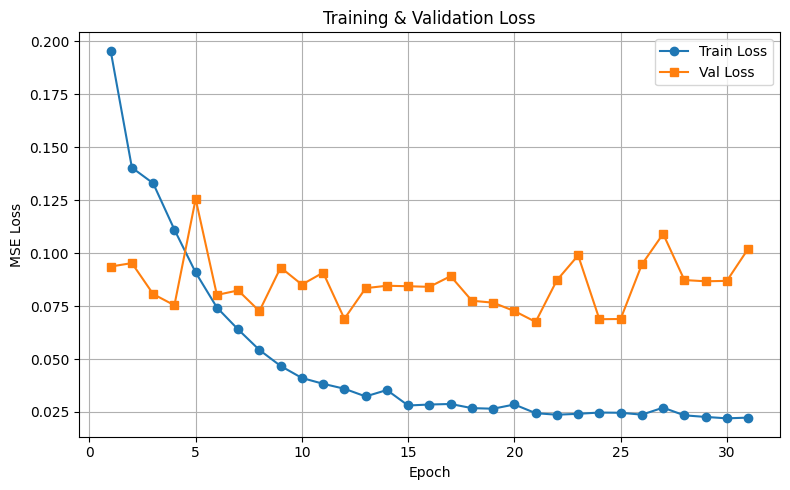

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [2]:
%run setup_path.py
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.utils.logger import Logger

from pathlib import Path
import torch
import torch.nn as nn

# ===========================
# lstm_pipeline_full.py
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



class LSTMTrainerPipeline:
    def __init__(self,
                 data_folder,
                 scaler_zip,
                 model_save_path,
                 window_size=30,
                 batch_size=64,
                 hidden_dim=128,
                 num_layers=2,
                 lr=1e-3,
                 num_epochs=100,
                 patience=20,
                 device=None):
        self.data_folder = Path(data_folder)
        self.scaler_loader = ScalingZipLoader(scaler_zip)
        self.window_size = window_size
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lr = lr
        self.num_epochs = num_epochs
        self.patience = patience
        self.model_save_path = Path(model_save_path)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.logger = Logger()
        self.model = None

    # -----------------------------
    # Load & preprocess data
    # -----------------------------
    def prepare_data(self, target_column_index=1):
        csv_files = list(self.data_folder.glob("*.csv"))
        if not csv_files:
            raise FileNotFoundError(f"No CSV files in {self.data_folder}")

        X_all, y_all = [], []
        for f in csv_files:
            df = pd.read_csv(f)
            # Scale input and output
            X_scaled = self.scaler_loader.transform_input(df.iloc[:, 0:1].values)
            y_scaled = self.scaler_loader.transform_input(df.iloc[:, 1:2].values)
            data = np.column_stack((X_scaled, y_scaled))
            X_seq, y_seq = create_sequences(data, self.window_size)
            X_all.append(X_seq)
            y_all.append(y_seq)

        X_all = np.concatenate(X_all, axis=0)
        y_all = np.concatenate(y_all, axis=0)

        # Split train / val / test
        n_total = len(X_all)
        n_test = int(0.1 * n_total)
        n_val = int(0.1 * n_total)
        n_train = n_total - n_test - n_val

        train_dataset = TensorDataset(torch.tensor(X_all[:n_train], dtype=torch.float32),
                                      torch.tensor(y_all[:n_train], dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_all[n_train:n_train+n_val], dtype=torch.float32),
                                    torch.tensor(y_all[n_train:n_train+n_val], dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(X_all[-n_test:], dtype=torch.float32),
                                     torch.tensor(y_all[-n_test:], dtype=torch.float32))

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    # -----------------------------
    # Build LSTM model
    # -----------------------------
    def build_model(self, input_dim=2, output_dim=1):
        self.model = LSTM_MODEL(input_dim=input_dim,
                                hidden_dim=self.hidden_dim,
                                num_layers=self.num_layers,
                                output_dim=output_dim)
        self.model.to(self.device)

    # -----------------------------
    # Training loop
    # -----------------------------
    def train(self):
        if self.model is None:
            raise RuntimeError("Model is not built. Call build_model() first.")

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        best_val_loss = float("inf")
        patience_counter = 0

        for epoch in range(1, self.num_epochs+1):
            train_loss = self._run_epoch(self.train_loader, optimizer, criterion, train=True)
            val_loss = self._run_epoch(self.val_loader, optimizer, criterion, train=False)

            self.logger.add_data_log(["epoch", "train_loss", "val_loss"],
                                     [[epoch], [train_loss], [val_loss]])

            print(f"Epoch {epoch} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), self.model_save_path)
                print(f"✅ Model saved at {self.model_save_path}")
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print("🛑 Early stopping triggered")
                    break

    def _run_epoch(self, loader, optimizer, criterion, train=True):
        self.model.train() if train else self.model.eval()
        total_loss = 0
        with torch.set_grad_enabled(train):
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device).unsqueeze(-1)
                y_pred = self.model(X_batch)
                loss = criterion(y_pred, y_batch)
                if train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                total_loss += loss.item() * X_batch.size(0)
        return total_loss / len(loader.dataset)

    # -----------------------------
    # Plot training loss
    # -----------------------------
    def plot_loss(self, save_path=None):
        df = self.logger.df
        plt.figure(figsize=(8,5))
        plt.plot(df['epoch'], df['train_loss'], marker='o', label="Train Loss")
        plt.plot(df['epoch'], df['val_loss'], marker='s', label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title("Training & Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

    # -----------------------------
    # Test model & inverse scale
    # -----------------------------
    def test(self):
        self.model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for X_batch, y_batch in self.test_loader:
                X_batch = X_batch.to(self.device)
                y_pred = self.model(X_batch).cpu().numpy()
                preds.append(y_pred)
                targets.append(y_batch.numpy())
        preds = np.concatenate(preds, axis=0)
        targets = np.concatenate(targets, axis=0)
        # Inverse scale
        preds_inv = self.scaler_loader.inverse_output(preds)
        targets_inv = self.scaler_loader.inverse_output(targets)
        return preds_inv, targets_inv

    # -----------------------------
    # Plot predictions vs target
    # -----------------------------
    def plot_predictions(self, preds, targets, save_path=None):
        plt.figure(figsize=(10,5))
        plt.plot(targets, label="Ground Truth")
        plt.plot(preds, label="Predicted", alpha=0.8)
        plt.xlabel("Sample")
        plt.ylabel("Output")
        plt.title("Prediction vs Ground Truth")
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()


# ==========================================================
# Example usage
# ==========================================================
if __name__ == "__main__":
    # -----------------------------
    DATA_FOLDER = Path(r"D:\Project_end\New_world\my_project\data\raw")
    SCALER_ZIP = Path(r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_scalers.zip")
    MODEL_SAVE = Path(r"D:\Project_end\New_world\my_project\models\lstm_model.pth")
    # -----------------------------
    pipeline = LSTMTrainerPipeline(
        data_folder=DATA_FOLDER,
        scaler_zip=SCALER_ZIP,
        model_save_path=MODEL_SAVE,
        window_size=30,
        batch_size=32,
        hidden_dim=64,
        num_layers=2,
        lr=1e-3,
        num_epochs=50,
        patience=10
    )

    # Prepare data
    pipeline.prepare_data()
    # Build model
    pipeline.build_model(input_dim=2, output_dim=1)
    # Train
    pipeline.train()
    # Plot loss
    pipeline.plot_loss()
    # Test
    preds, targets = pipeline.test()
    # Plot prediction vs true
    pipeline.plot_predictions(preds, targets)



✅ Successfully loaded artifacts from: RC_Tank_Env_scalers.zip
Epoch 1/100, Train Loss: 0.1265, Val Loss: 0.0763
Epoch 2/100, Train Loss: 0.1153, Val Loss: 0.0747
Epoch 3/100, Train Loss: 0.0611, Val Loss: 0.0514
Epoch 4/100, Train Loss: 0.0863, Val Loss: 0.0542
Epoch 5/100, Train Loss: 0.0491, Val Loss: 0.0490
Epoch 6/100, Train Loss: 0.0637, Val Loss: 0.0541
Epoch 7/100, Train Loss: 0.0934, Val Loss: 0.0518
Epoch 8/100, Train Loss: 0.0708, Val Loss: 0.0494
Epoch 9/100, Train Loss: 0.0718, Val Loss: 0.0490
Epoch 10/100, Train Loss: 0.0876, Val Loss: 0.0490
Epoch 11/100, Train Loss: 0.0794, Val Loss: 0.0491
Epoch 12/100, Train Loss: 0.0780, Val Loss: 0.0507
Epoch 13/100, Train Loss: 0.0647, Val Loss: 0.0502
Epoch 14/100, Train Loss: 0.0921, Val Loss: 0.0498
Epoch 15/100, Train Loss: 0.0929, Val Loss: 0.0495
Epoch 16/100, Train Loss: 0.0863, Val Loss: 0.0490
Epoch 17/100, Train Loss: 0.0947, Val Loss: 0.0501
Epoch 18/100, Train Loss: 0.0922, Val Loss: 0.0495
Epoch 19/100, Train Loss: 0.0

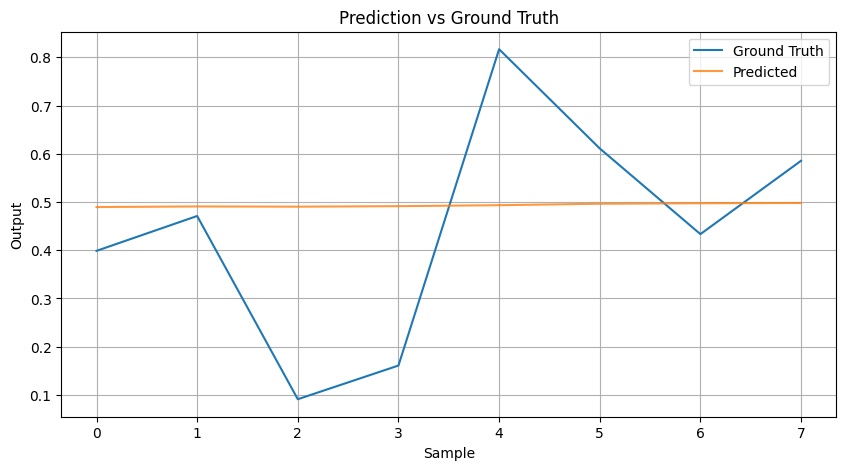

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import joblib
import yaml
import io
import warnings

# =============================================================================
# Helper Functions and Classes (from uploaded files)
# =============================================================================

class ScalingZipLoader:
    def __init__(self, zip_path: str | Path):
        self.zip_path = Path(zip_path)
        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ZIP file not found at: {self.zip_path}")
        self._load_from_zip()
        print(f"✅ Successfully loaded artifacts from: {self.zip_path.name}")

    def _load_from_zip(self):
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            self.scaler_in = self._load_joblib_from_zip(zipf, "input_scaler.pkl")
            self.scaler_out = self._load_joblib_from_zip(zipf, "output_scaler.pkl")
            self.metadata = self._load_yaml_from_zip(zipf, "metadata.yaml")

    def _load_joblib_from_zip(self, zipf, filename):
        with zipf.open(filename) as f:
            with io.BytesIO(f.read()) as bio:
                return joblib.load(bio)

    def _load_yaml_from_zip(self, zipf, filename):
        with zipf.open(filename) as f:
            return yaml.safe_load(f)

    def transform_input(self, data):
        return self.scaler_in.transform(data)

    def inverse_transform_input(self, data):
        return self.scaler_in.inverse_transform(data)

    def transform_output(self, data):
        return self.scaler_out.transform(data)

    def inverse_transform_output(self, data):
        return self.scaler_out.inverse_transform(data)

    def summary(self):
        print("="*50)
        print("          Scaling Loader Summary")
        print("="*50)
        print(f"Loaded from: {self.zip_path.name}")
        if self.metadata:
            print("\nMetadata:")
            print(yaml.dump(self.metadata, indent=2))
        else:
            print("\nNo metadata found.")
        print("="*50)


def create_sequences(data: np.ndarray, window_size: int):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size, 1])
    return np.array(X), np.array(y)


class LSTM_MODEL(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.1):
        super(LSTM_MODEL, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class Logger:
    def __init__(self):
        self.df = pd.DataFrame()

    def add_data_log(self, columns_name, data_list):
        new_data = {col: data for col, data in zip(columns_name, data_list)}
        if self.df.empty:
            self.df = pd.DataFrame(new_data)
        else:
            new_rows = pd.DataFrame(new_data)
            self.df = pd.concat([self.df, new_rows], ignore_index=True)

# =============================================================================
# Main Pipeline Class
# =============================================================================

class LSTMTrainingPipeline:
    def __init__(self,
                 data_folder,
                 scaler_zip,
                 model_save_path,
                 window_size=30,
                 batch_size=64,
                 hidden_dim=128,
                 num_layers=2,
                 lr=1e-3,
                 num_epochs=100,
                 patience=20,
                 device=None):
        self.data_folder = Path(data_folder)
        self.scaler_loader = ScalingZipLoader(scaler_zip)
        self.window_size = window_size
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lr = lr
        self.num_epochs = num_epochs
        self.patience = patience
        self.model_save_path = Path(model_save_path)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.logger = Logger()
        self.model = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def prepare_data(self):
        csv_files = list(self.data_folder.glob("*.csv"))
        if not csv_files:
            raise FileNotFoundError(f"No CSV files in {self.data_folder}")

        X_all, y_all = [], []
        for f in csv_files:
            df = pd.read_csv(f)
            X_scaled = self.scaler_loader.transform_input(df.iloc[:, 0:1].values)
            y_scaled = self.scaler_loader.transform_output(df.iloc[:, 1:2].values) # Corrected to use transform_output
            data = np.column_stack((X_scaled, y_scaled))
            X_seq, y_seq = create_sequences(data, self.window_size)
            X_all.append(X_seq)
            y_all.append(y_seq)

        X_all = np.concatenate(X_all, axis=0)
        y_all = np.concatenate(y_all, axis=0)

        n_total = len(X_all)
        n_test = int(0.1 * n_total)
        n_val = int(0.1 * n_total)
        n_train = n_total - n_test - n_val

        train_dataset = TensorDataset(torch.tensor(X_all[:n_train], dtype=torch.float32),
                                      torch.tensor(y_all[:n_train], dtype=torch.float32).unsqueeze(1)) # Added unsqueeze
        val_dataset = TensorDataset(torch.tensor(X_all[n_train:n_train+n_val], dtype=torch.float32),
                                    torch.tensor(y_all[n_train:n_train+n_val], dtype=torch.float32).unsqueeze(1)) # Added unsqueeze
        test_dataset = TensorDataset(torch.tensor(X_all[-n_test:], dtype=torch.float32),
                                     torch.tensor(y_all[-n_test:], dtype=torch.float32).unsqueeze(1)) # Added unsqueeze

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    def build_model(self):
        input_dim = self.train_loader.dataset.tensors[0].shape[2]
        self.model = LSTM_MODEL(input_dim=input_dim,
                                hidden_dim=self.hidden_dim,
                                num_layers=self.num_layers,
                                output_dim=1).to(self.device)

    def train(self):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in self.train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            val_loss = self.evaluate(self.val_loader)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.model_save_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping")
                    break
        self.model.load_state_dict(torch.load(self.model_save_path))

    def evaluate(self, data_loader):
        self.model.eval()
        total_loss = 0
        criterion = nn.MSELoss()
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()
        return total_loss / len(data_loader)

    def predict(self, data_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for X_batch, _ in data_loader:
                X_batch = X_batch.to(self.device)
                outputs = self.model(X_batch)
                predictions.append(outputs.cpu().numpy())
        return np.concatenate(predictions)

    def plot_predictions(self, save_path=None):
        preds = self.predict(self.test_loader)
        targets = self.test_loader.dataset.tensors[1].numpy()
        preds = self.scaler_loader.inverse_transform_output(preds)
        targets = self.scaler_loader.inverse_transform_output(targets)

        plt.figure(figsize=(10, 5))
        plt.plot(targets, label="Ground Truth")
        plt.plot(preds, label="Predicted", alpha=0.8)
        plt.xlabel("Sample")
        plt.ylabel("Output")
        plt.title("Prediction vs Ground Truth")
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def run(self):
        self.prepare_data()
        self.build_model()
        self.train()
        test_loss = self.evaluate(self.test_loader)
        print(f"Test Loss: {test_loss:.4f}")
        self.plot_predictions()


if __name__ == "__main__":
    # You need to adjust these paths to your local machine
    DATA_FOLDER = Path("./data/raw")
    SCALER_ZIP = Path("./config/RC_Tank_Env_scalers.zip")
    MODEL_SAVE = Path("./models/lstm_model.pth")
    
    # Create dummy data and scaler for testing if they don't exist
    if not DATA_FOLDER.exists():
        DATA_FOLDER.mkdir(parents=True)
        pd.DataFrame({'PWM_duty': np.random.rand(100), 'Tank_level': np.random.rand(100)}).to_csv(DATA_FOLDER / 'dummy_data.csv', index=False)
        
    if not SCALER_ZIP.parent.exists():
        SCALER_ZIP.parent.mkdir(parents=True)

    if not SCALER_ZIP.exists():
        from sklearn.preprocessing import MinMaxScaler
        import zipfile
        import joblib
        import yaml

        # Create dummy scalers
        scaler_in = MinMaxScaler()
        scaler_out = MinMaxScaler()
        dummy_data = np.random.rand(100, 2)
        scaler_in.fit(dummy_data[:, 0].reshape(-1, 1))
        scaler_out.fit(dummy_data[:, 1].reshape(-1, 1))

        # Save scalers and metadata to a zip file
        with zipfile.ZipFile(SCALER_ZIP, 'w') as zf:
            joblib.dump(scaler_in, 'input_scaler.pkl')
            joblib.dump(scaler_out, 'output_scaler.pkl')
            with open('input_scaler.pkl', 'rb') as f:
                zf.writestr('input_scaler.pkl', f.read())
            with open('output_scaler.pkl', 'rb') as f:
                zf.writestr('output_scaler.pkl', f.read())

            metadata = {'input_features': ['PWM_duty'], 'output_features': ['Tank_level']}
            with open('metadata.yaml', 'w') as f:
                yaml.dump(metadata, f)
            with open('metadata.yaml', 'r') as f:
                zf.writestr('metadata.yaml', f.read())

    if not MODEL_SAVE.parent.exists():
        MODEL_SAVE.parent.mkdir(parents=True)


    pipeline = LSTMTrainingPipeline(
        data_folder=DATA_FOLDER,
        scaler_zip=SCALER_ZIP,
        model_save_path=MODEL_SAVE,
        window_size=20, # Reduced for dummy data
        batch_size=16,
        hidden_dim=128,
        num_layers=3,
        lr=1e-3,
        num_epochs=100,
        patience=50,
    )
    pipeline.run()